In [1]:
import pandas as pd
import numpy as np

from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

In [2]:
df = pd.read_csv('../data/comb_clean_pitcher.csv', index_col=False)

In [3]:
df.head()

,player_name,pitcher,batter,stand,pitch_type,pitch_number,outs_when_up,times_faced,XBH,large_score_dif,recent_pitch,second_recent_pitch,third_recent_pitch,pitch_count
0,"Rodriguez, Grayson",680570,543760,R,FB,4,0,1,0,0,14.0 - SL - ball,2.0 - FB - foul,14.0 - FB - ball,2-1
1,"Rodriguez, Grayson",680570,543760,R,SL,5,0,1,0,0,9.0 - FB - called,14.0 - SL - ball,2.0 - FB - foul,2-2
2,"Rodriguez, Grayson",680570,543760,R,FB,6,0,1,0,0,14.0 - SL - ball,9.0 - FB - called,14.0 - SL - ball,3-2
3,"Rodriguez, Grayson",680570,608369,L,FB,4,0,1,0,0,14.0 - CH - ball,14.0 - CH - ball,4.0 - FB - called,2-1
4,"Rodriguez, Grayson",680570,608369,L,CH,5,0,1,0,0,3.0 - FB - foul,14.0 - CH - ball,14.0 - CH - ball,2-2


In [4]:
df_bi = df.drop(df[df['pitch_count'] == '4-2'].index)

In [5]:
df_bi.dropna(axis=0, inplace=True)

In [6]:
df_bi.isna().sum()

player_name            0
pitcher                0
batter                 0
stand                  0
pitch_type             0
pitch_number           0
outs_when_up           0
times_faced            0
XBH                    0
large_score_dif        0
recent_pitch           0
second_recent_pitch    0
third_recent_pitch     0
pitch_count            0
dtype: int64

In [7]:
def transform_pitch_types(column):
    """
    Transform specific pitch types in a column to 'OS'.
    'SL', 'CH', 'CB' are changed to 'OS', other values are left unchanged.

    Args:
    column (pd.Series): A pandas Series representing the column to be transformed.

    Returns:
    pd.Series: The transformed column.
    """
    # Mapping specific pitch types to 'OS'
    pitch_map = {'SL': 'OS', 'CH': 'OS', 'CB': 'OS'}

    # Using the map function to apply the transformation
    return column.map(lambda x: pitch_map.get(x, x))

In [8]:
def transform_pitch_types_in_string(column):
    """
    Transform specific substrings in a column to 'OS'.
    Substrings 'SL', 'CH', 'CB' are changed to 'OS', other parts of the string are left unchanged.

    Args:
    column (pd.Series): A pandas Series representing the column to be transformed.

    Returns:
    pd.Series: The transformed column.
    """
    def replace_substring(pitch):
        # Replace specific substrings with 'OS'
        for sub in ['SL', 'CH', 'CB']:
            pitch = pitch.replace(sub, 'OS')
        return pitch

    return column.apply(replace_substring)

In [9]:
df_bi_clean = df_bi.copy()
df_bi_clean['pitch_type'] = transform_pitch_types(df_bi_clean['pitch_type'])
df_bi_clean['recent_pitch'] = transform_pitch_types_in_string(df_bi_clean['recent_pitch'])
df_bi_clean['second_recent_pitch'] = transform_pitch_types_in_string(df_bi_clean['second_recent_pitch'])
df_bi_clean['third_recent_pitch'] = transform_pitch_types_in_string(df_bi_clean['third_recent_pitch'])

In [10]:
df_bi_clean.head()

,player_name,pitcher,batter,stand,pitch_type,pitch_number,outs_when_up,times_faced,XBH,large_score_dif,recent_pitch,second_recent_pitch,third_recent_pitch,pitch_count
0,"Rodriguez, Grayson",680570,543760,R,FB,4,0,1,0,0,14.0 - OS - ball,2.0 - FB - foul,14.0 - FB - ball,2-1
1,"Rodriguez, Grayson",680570,543760,R,OS,5,0,1,0,0,9.0 - FB - called,14.0 - OS - ball,2.0 - FB - foul,2-2
2,"Rodriguez, Grayson",680570,543760,R,FB,6,0,1,0,0,14.0 - OS - ball,9.0 - FB - called,14.0 - OS - ball,3-2
3,"Rodriguez, Grayson",680570,608369,L,FB,4,0,1,0,0,14.0 - OS - ball,14.0 - OS - ball,4.0 - FB - called,2-1
4,"Rodriguez, Grayson",680570,608369,L,OS,5,0,1,0,0,3.0 - FB - foul,14.0 - OS - ball,14.0 - OS - ball,2-2


In [11]:
X = df_bi_clean.drop(columns=['player_name', 'pitcher', 'batter', 'pitch_type', 'pitch_number'])
y = df_bi_clean['pitch_type']

In [12]:
# Initialize OneHotEncoder
ohe = OneHotEncoder(sparse=False, handle_unknown='error', drop='first')

# Split the encoded data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [13]:
from sklearn.dummy import DummyClassifier

dc = DummyClassifier(strategy='most_frequent')

In [14]:
dc.fit(X_train, y_train)

DummyClassifier(strategy='most_frequent')

In [15]:
dc.score(X_test, y_test)

0.540991461927165

In [16]:
from sklearn.compose import ColumnTransformer

# Create a column transformer to apply encoding only to the categorical columns
preprocessor = ColumnTransformer(transformers=
                                 [('cat', ohe, [0, 1, 2, 3, 4, 5, 6, 7, 8])],
                                 remainder='passthrough')

In [24]:
preprocessor.fit(X_train)

X_train_transformed = preprocessor.transform(X_train)

C:\Users\bassn\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [18]:
preprocessor.transform(X_test).shape

(22956, 333)

In [19]:
from sklearn.neural_network import MLPClassifier

#Build pipeline to train MLP
pipe = Pipeline([('ct', preprocessor), ('mlp', MLPClassifier())])

In [20]:
from sklearn.model_selection import RandomizedSearchCV

In [21]:
# Define the parameter distribution
param_dist = {
    'mlp__max_iter': [750, 1000, 1250],
    'mlp__hidden_layer_sizes': [(10, 30, 10)],
    'mlp__activation': ['relu', 'tanh'],
    'mlp__solver': ['sgd'],
    'mlp__alpha': [0.05, 0.075, 0.1],
    'mlp__tol': [1e-6, 1e-7, 1e-8]
}

# Create a RandomizedSearchCV object
clf = RandomizedSearchCV(estimator=pipe, param_distributions=param_dist, n_iter=54, cv=5, random_state=42, n_jobs=-1)

# Fit the model
clf.fit(X_train, y_train)

C:\Users\bassn\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\bassn\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (750) reached and the optimization hasn't converged yet.
  warnings.warn(


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('ct',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('cat',
                                                                               OneHotEncoder(drop='first',
                                                                                             sparse=False),
                                                                               [0,
                                                                                1,
                                                                                2,
                                                                                3,
                                                                                4,
                                                                                5,
                                                                                6,
                                                                                7,
                                                                                8])])),
                                             ('mlp', MLPClassifier())]),
                   n_iter=54, n_jobs=-1,
                   param_distributions={'mlp__activation': ['relu', 'tanh'],
                                        'mlp__alpha': [0.05, 0.075, 0.1],
                                        'mlp__hidden_layer_sizes': [(10, 30,
                                                                     10)],
                                        'mlp__max_iter': [750, 1000, 1250],
                                        'mlp__solver': ['sgd'],
                                        'mlp__tol': [1e-06, 1e-07, 1e-08]},
                   random_state=42)

In [22]:
# Get the best parameters and score
best_parameters = clf.best_params_
best_score = clf.best_score_

print(f"Best Parameters: {best_parameters}")
print(f"Best Score: {best_score}")

Best Parameters: {'mlp__tol': 1e-07, 'mlp__solver': 'sgd', 'mlp__max_iter': 750, 'mlp__hidden_layer_sizes': (10, 30, 10), 'mlp__alpha': 0.1, 'mlp__activation': 'tanh'}
Best Score: 0.6029100597291744


In [22]:
mlp_best = MLPClassifier(tol=1e-07, solver='sgd', max_iter=750, hidden_layer_sizes = (10, 30, 10), alpha=0.1, activation='tanh')

In [25]:
mlp_best.fit(X_train_transformed, y_train)

MLPClassifier(activation='tanh', alpha=0.1, hidden_layer_sizes=(10, 30, 10),
              max_iter=750, solver='sgd', tol=1e-07)

In [26]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

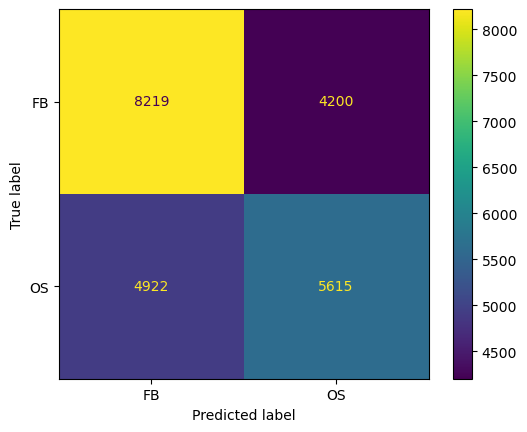

In [28]:
X_test_transformed = preprocessor.transform(X_test)
y_pred = mlp_best.predict(X_test_transformed)
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm, display_labels=mlp_best.classes_).plot();

In [31]:
from sklearn.metrics import roc_curve, RocCurveDisplay

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


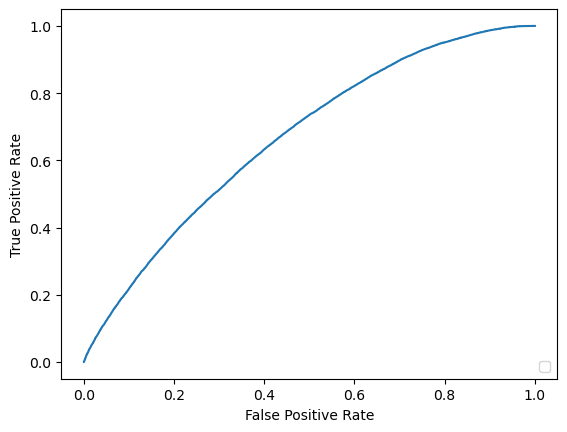

In [34]:
y_train_score = mlp_best.predict_proba(X_train_transformed)[:, 1]

fpr2, tpr2, _ = roc_curve(y_train, y_train_score, pos_label=mlp_best.classes_[1])
roc_display = RocCurveDisplay(fpr=fpr2, tpr=tpr2).plot();

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


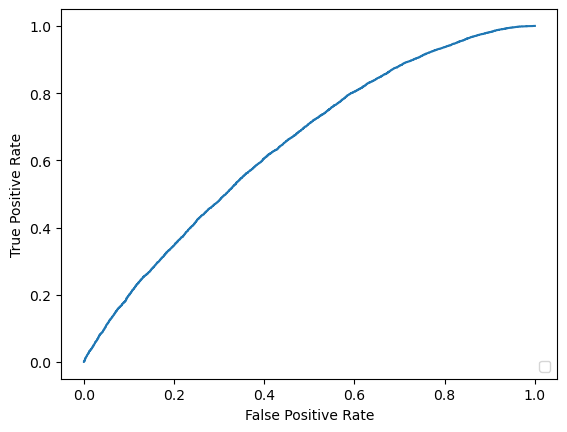

In [32]:
y_score = mlp_best.predict_proba(X_test_transformed)[:, 1]

fpr, tpr, _ = roc_curve(y_test, y_score, pos_label=mlp_best.classes_[1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot();